In [64]:
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

import plotly.io as pio
pio.renderers.default= 'png'# to export on git and have plot shown : to have interactive = 'notebook'
pio.renderers["png"].height = 600
pio.renderers["png"].width = 900

def churn_rate_agg(x):
    return 1-x.mean()
import pycountry_convert as pc

def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    try:
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)

    except KeyError as ke:
        #only SX not found 
        country_continent_name = 'North America'
        #print('continent not found ', country_alpha2)
    return country_continent_name


In [65]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# Home Exchange Presentation

https://www.homeexchange.com/


HomeExchange is a new way to travel.




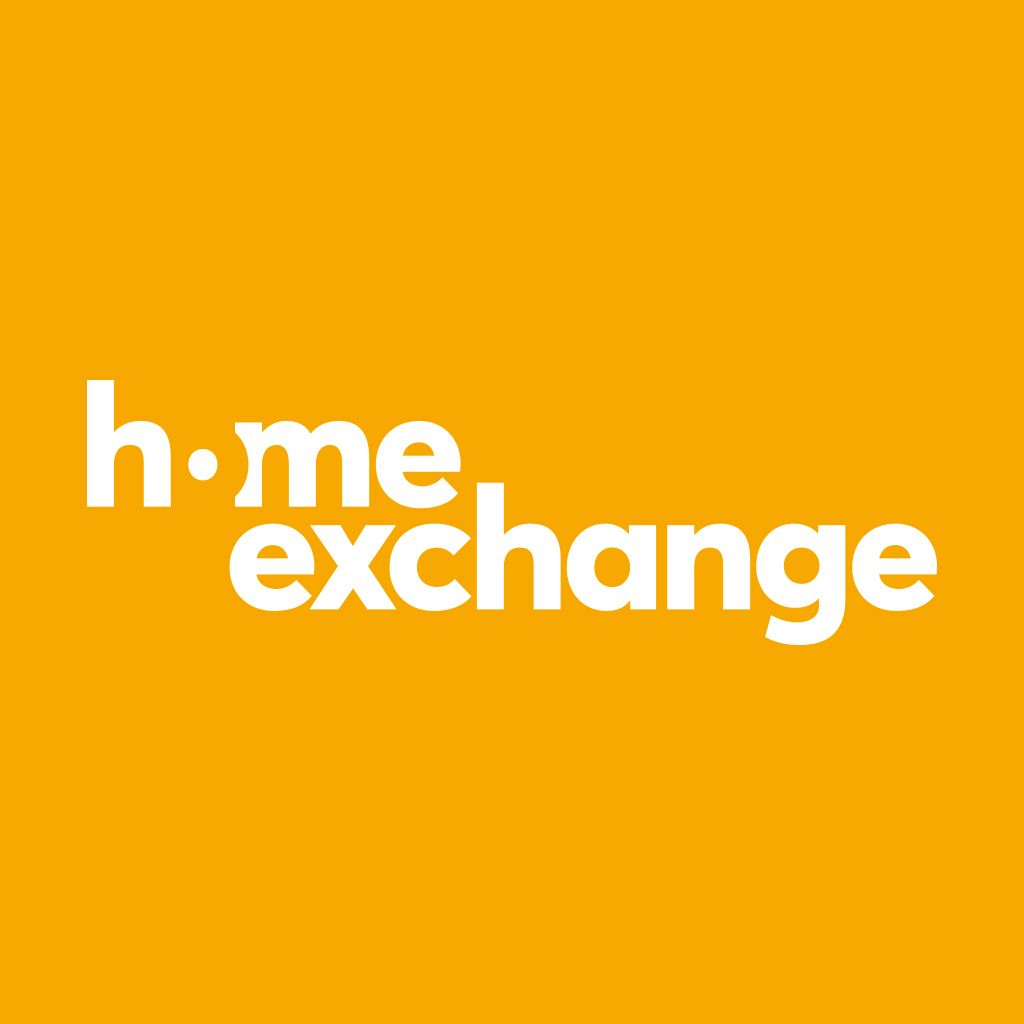

In [66]:
from IPython.display import Image
Image(filename='../plot/homeexchange_slack.jpg', width=400)

It is a major alternative to Airbnb where you can swap houses. Registration is free, and you only pay the annual membership fee of €160 when you find your first exchange.

Subscribing to the annual membership also gives you access to Guest Points (500GP for the first subscription and 250GP for subsequent ones).

Guest Points were created to enable non-reciprocal exchanges when members cannot find someone to host them on the dates they would like to travel. 

Thanks to this system, users are able to organize two types of exchanges on HomeExchange:

   - Reciprocal: User1 hosts the person (User2) whose home User1 is staying in (both User1 and User2 are both the host and the guest).
   - Non-reciprocal: One member of the exchange is not interested in going to the other's home, so they offer a predetermined amount of Guest Points per night for their hospitality. The user can be either the host or the guest. For example, imagine that a German couple wants to come to your home, but you wish to travel to Italy, not Germany. Without Guest Points, a simple reciprocal exchange would not be possible in that case. However, with Guest Points, the German couple can come stay in your home in exchange for Guest Points. You can then use these Guest Points to stay in a home in Italy. Guest Points exist to compensate for the hospitality of a host.



## Problem presentation 

HomeExchange needs to understand why some of their customers leave. 

Several variables are available to identify whether seniority, activity as a guest or host, sponsorship, and subscriptions taken through promotions have an impact on the churn rate.



## Data description

Two datasets are provided by HomeExchange : 
 - **Exchanges**: 
     - One line by exchanges initiated or received by users who have register (but not necessary subscribed).
     - If exchanges is reciprocal, only one conversation is created (via the creator_id), but two exchanges are created.
     - Data : 
         - conversation_id : id of the conversation	(not unique)
         - exchange_id : exchange id which is unique, even in case of reciprocal exchange (in this case conversation_id is the same for both exchange)
         - created_at :date of conversation creation
         - creator_id :user_id of the user that who initiated the conversation
         - guest_user_id : user_id of the (potential) guest	
         - host_user_id : user_id of the (potential) host	N	
         - finalized_at : date when the exchange was finalized (if null, it means that the exchange request was not successful)	
         - canceled_at: date when the finalized exchange has been cancelled		
         - start_on: date when the exchange starts (can be filled in even if the exchange is not finalized. It corresponds to the requested dates)		
         - end_on: date when the exchange ends (can be filled in even if the exchange is not finalized. It corresponds to the requested dates)		
         - guest_count : number of people coming
         - night_count: number of nights of the exchange		
         - user_cancellation_id: user_id who canceled		
         - exchange_type: via Guest Points or reciprocal		
         - home_type: house or appartment		
         - residence_type: main or secondary house		
         - capacity: maximum number of people who can come		
         - country: host house country		
         - region: host house region		
         - department: host house department		
         - city: host house city		
 - **Subscription**: 
     - One line per subscription (for subscription > 2019). 
     - **/!\ subscription in 2019** can be a renew of a first subscription older than 2019
     - If a user has subscribed several years, there are as many lines as subscriptions. 
     - If renew = 1 , you will find the subscription line and the renewal line for the next year
     - Data : 
         - subscription_date : date of subscription of the user (can be a renew (not the first subscription))	N	
         - user_id : id of the user
         - renew : did the user re-subscribe the following year (the month of the expiration of his subscription)		
         - first_subscription_date : date of the first subscription (can be before 2019)		
         - first_subscription : 1 if it's the first subscription of the user			
         - referral : 1 if the user has been sponsored		
         - promotion : 1 if the user had a promotion for his/her subscription		
         - payment3x : 1 if the user has used the 3x payment to subscribe		
         - payment2 : 1 if the user hashas paid his/her 2nd payment		
         - payment3 : 1 if the user hashas paid his/her 3nd payment		
         - country : user country, if null, it might be a renew and the info is not saved here. Info will be retrieved in exchanges data file		
         - region : user region, if null, it might be a renew and the info is not saved here. Info will be retrieved in exchanges data file		
         - department : city : user city, if null, it might be a renew and the info is not saved here. Info will be retrieved in exchanges data file
         
         
Datasets cover period from 2019-01-01 to 2022-11-30. As subscription are for one year, the maximal date subscription date is '2021-10-31'.

Some cleaning and data enrichment was done in SQL (DBT) :
  - Cleaning : 
      - Exchange data : 
          - Remove duplicated row 
          - Remove line were host and guest was the same user 
      - Subscription data : 
          - Remove duplicated row 
          - Remove user were there were more than 3 subscriptions in 3 years (not normal since subscription are annual)
          - Add missing country, city and region info based on Exchange data (where user was host)
  - Enrichment : 
      - Subscription data, add the following information :
          - is_zombie : 1 if the user subscribe again after 1 year of absence (due to covid for example)		
          - previous_inscription_date : date of the previous subscription	
          - inscription_diff_year : difference in year between subscription_date and previous_subscription_date		
          - nb_of_inscription_by_users : nb of subscription by users between 2019 and 2021. Can only be <=3 (selection done on this key for removing strange behavior with more than 1 subscription per year)
         
**A new table was created in SQL BigQuery**

 - **User**: 
   - In this table, information such as the number of subscription of the user, the number of time the user did an exchange etc.. are summarized by users (one line per user)
   - It is an join between Subscription and Exchange table
   - Data : 
     - user_id : user_id, user can be a subscriber or not (in this case first subscription date is null)		
     - first_subscription_date : date of the first subscription (is any) of the user		
     - last_subscription_date : date of the last subscription (is any between 2019 and 2021) of the user		
     - nb_of_inscription : number of subscription of the user between 2019 and 2021 (can be more if user subscribe before 2019)	
     - mean_churn_rate : for subscription between 2019 and 2021, give the average churn rate for the user (for example, 3 subscription but only 2 renew, churn rate = 1 - 2/3 = 0.33)		
     - referall : 1 if the user were at least referall once, 0 if the user was never refer		
     - promotion : 1 if the user used at least one promotion, 0 if the user never used promotion		
     - country : country of the user		
     - nb_of_conversation_as_host : count the total number of conversation created were the user is host		
     - nb_of_conversation_as_host_notFinalized : count the total number of conversation that DID not become an exchange, were the user is host		
     - nb_of_exchange_as_host_done : count the total number of conversation that DID become an exchange and WAS NOT CANCEL, were the user is host	
     - first_date_exchange_as_host_done :  finalized (not date of travel) date of the first exchange of the user as host (between 2019 and 2022, for older user it can be anterior to this)
     - nb_of_exchange_as_host_canceled : count the total number of conversation that DID become an exchange and WAS CANCEL, were the user is host		
     - nb_of_conversation_as_guest : count the total number of conversation created were the user is guest		
     - nb_of_conversation_as_guest_notFinalized : count the total number of conversation that DID not become an exchange, were the user is guest		
     - nb_of_exchange_as_guest_done : count the total number of conversation that DID become an exchange and WAS NOT CANCEL, were the user is guest	
     - first_date_exchange_as_host_done :  finalized (not date of travel) date of the first exchange of the user as guest (between 2019 and 2022, for older user it can be anterior to this)
     - nb_of_exchange_as_guest_canceled : count the total number of conversation that DID become an exchange and WAS CANCEL, were the user is guest		
     - nb_of_conversation_for_exchange : count the total number of conversation created for reciprocal exchange (user is both guest and host)		
     - nb_of_conversation_for_exchange_notFinalized : count the total number of conversation that DID NOT become an exchange (user is both guest and host)		
     - nb_of_exchange_as_exchange_done : count the total number of conversation that DID become an exchange and WAS NOT cancel for reciprocal exchange (user is both guest and host)
     - first_date_exchange_as_host_done : finalized (not date of travel) date of the first exchange of the user as both guest and host (between 2019 and 2022, for older user it can be anterior to this)
     - nb_of_exchange_as_exchange_canceled : count the total number of conversation that DID become an exchange and WAS cancel for reciprocal exchange (user is both guest and host)
     - total_exchange_done : total of exchange done by one users during the period (2019 - 2022)


# Load data 

Subscription data : 

In [67]:
## Loadind dataset 
print('loading subscription dataset....')
df_subs = pd.read_hdf('../data/subscription.h5', key='data')

len_=len(df_subs)

# DONE IN SQL
# #remove multiple inscription in same year while it's an annual subscription
# multiplesub = df_subs.groupby('user_id').agg({'pk':'count', 'renew':'mean'})
# print(len(multiplesub[multiplesub.pk>=4]))
# df_subs=df_subs[~df_subs.user_id.isin(multiplesub[multiplesub.pk>=4].index.values)]
# print(round(100-(len(df_subs)/len_)*100,1), ' % of double inscription for same user in the same year')

# remove user wihtout country 
#df_subs = df_subs[df_subs.country.isnull()==False]

print('.... cleaning stage in SQL remove : ', round(100-len_/100000*100, 2) , '% of data')

# cast date
df_subs['first_subscription_date']= pd.to_datetime(df_subs['first_subscription_date'])
df_subs['subscription_date']= pd.to_datetime(df_subs['subscription_date'])
df_subs['previous_subscription_date']= pd.to_datetime(df_subs['previous_inscription_date'])
df_subs=df_subs.set_index('subscription_date')
# add continent info
df_subs['country'] = df_subs['country'].fillna('unknow')
df_subs['continent'] = df_subs["country"].apply(lambda x: country_to_continent(x) if x != 'unknow' else 'unknow')

loading subscription dataset....
.... cleaning stage in SQL remove :  4.37 % of data


Exchange data : 

In [68]:
print('loading exchange data')
df_exc = pd.read_hdf('../data/exchanges.h5', key='data')
df_exc['created_at']= pd.to_datetime(df_exc['created_at'])
df_exc=df_exc.set_index('created_at')

loading exchange data


In [69]:
# because of memory error
df_exc_1 = df_exc[df_exc.index<pd.to_datetime('2021-06-01', format='%Y-%m-%d')]

In [70]:
df_exc_2 = df_exc[df_exc.index>=pd.to_datetime('2021-06-01', format='%Y-%m-%d')]
df_exc = []

In [71]:
print('Resample exchange data (monthly)')
df_exc_monthly_1=df_exc_1.resample("M")[['exchange_id', 'finalized_at','canceled_at']].agg(['count', 'first'])
df_exc_monthly_1.columns = df_exc_monthly_1.columns.map('_'.join)
df_exc_monthly_1=df_exc_monthly_1.drop(columns='exchange_id_first')

df_exc_monthly_2=df_exc_2.resample("M")[['exchange_id', 'finalized_at','canceled_at']].agg(['count', 'first'])
df_exc_monthly_2.columns = df_exc_monthly_2.columns.map('_'.join)
df_exc_monthly_2=df_exc_monthly_2.drop(columns='exchange_id_first')

df_exc_monthly = pd.concat([df_exc_monthly_1,df_exc_monthly_2])

Resample exchange data (monthly)


In [72]:
df_exc_2 = []
df_exc_1 = []

Users data :

In [73]:
print('Load Users data')
df_users = pd.read_hdf('../data/users.h5')
df_users['country'] = df_users['country'].fillna('unknow')
df_users['continent'] = df_users["country"].apply(lambda x: country_to_continent(x) if x != 'unknow' else 'unknow')

df_non_subscriber = df_users[df_users.first_subscription_date.isnull()]
df_subscriber = df_users[~df_users.first_subscription_date.isnull()]



df_subscriber = df_subscriber.fillna(0)
df_subscriber['total_exchange_done'] = df_subscriber['nb_of_exchange_as_exchange_done'] + df_subscriber['nb_of_exchange_as_guest_done'] +  df_subscriber['nb_of_exchange_as_host_done']
df_subscriber_only_host = df_subscriber[(df_subscriber.nb_of_exchange_as_guest_done==0)
                                        &(df_subscriber.nb_of_exchange_as_host_done>0)
                                        &(df_subscriber.nb_of_exchange_as_exchange_done==0)]

df_subscriber_only_guest = df_subscriber[(df_subscriber.nb_of_exchange_as_guest_done>0)
                                        &(df_subscriber.nb_of_exchange_as_host_done==0)
                                        &(df_subscriber.nb_of_exchange_as_exchange_done==0)
                                        ]

df_subscriber_none = df_subscriber[(df_subscriber.nb_of_exchange_as_guest_done==0)
                                        &(df_subscriber.nb_of_exchange_as_host_done==0)
                                        &(df_subscriber.nb_of_exchange_as_exchange_done==0)]

df_subscriber_both = df_subscriber[(df_subscriber.nb_of_exchange_as_exchange_done>0)|
                                   ((df_subscriber.nb_of_exchange_as_guest_done>0)
                                    &(df_subscriber.nb_of_exchange_as_host_done>0))]

if (len(df_subscriber_only_host)+len(df_subscriber_only_guest)
    +len(df_subscriber_none)+len(df_subscriber_both)) != len(df_subscriber):
    print('missing data ?')
else : print(len(df_users))

Load Users data
414678


# Rating Score on TrustPilot 
Data gather thanks to web scrapping (see WebScrapping_Trustpilot notebook)

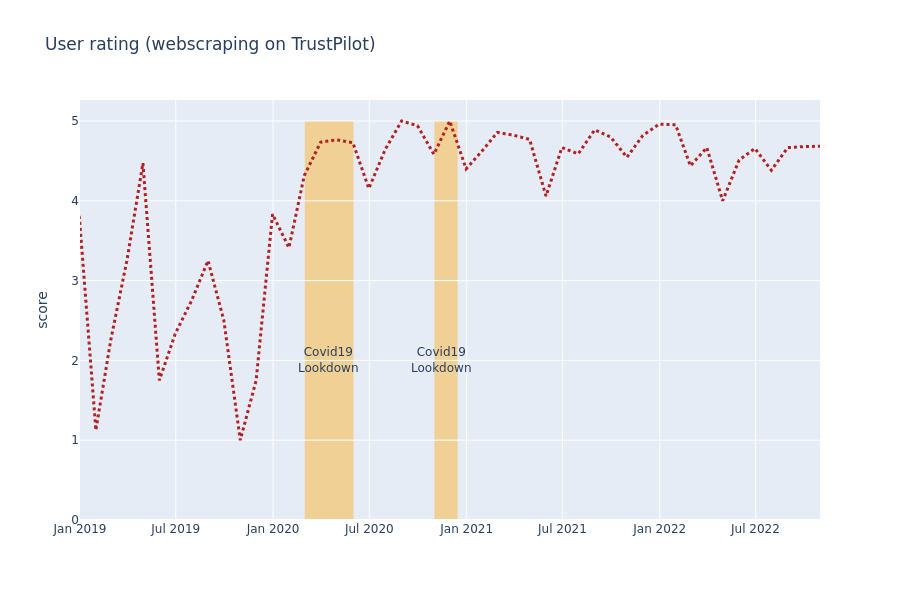

In [74]:
avis= pd.read_csv('../data/trustpilot_rating_scrapping.csv', usecols=['date','rating','country'])
avis['date']= pd.to_datetime(avis['date'])

avis = avis.set_index('date')
df_monthly  = avis.resample("M").agg({'country': 'count', 'rating':'mean'})
# Create figure with secondary y-axis
fig2 = make_subplots()#specs=[[{"secondary_y": True}]])

# Add traces
fig2.add_trace(
    go.Scatter(x=df_monthly.index, y=df_monthly.rating, 
               name="Mean rating",
               line = dict(color='firebrick', width=3, dash='dot')),
    secondary_y=False,
)

# specify the corners of the rectangles
covid_range = [dict(type="rect", xref="x", yref="y",
         x0="2020-03-01",y0="0",x1="2020-06-01",y1="5",
         fillcolor="orange",opacity=0.4,line_width=0,layer="below"),
               dict(type="rect", xref="x", yref="y",
         x0="2020-11-01",y0="0",x1="2020-12-15",y1="5",
         fillcolor="orange",opacity=0.4,line_width=0,layer="below") ]

covid_label = f"<br>".join([f"Covid19",f"Lookdown"])

fig2.update_layout(shapes=covid_range)

fig2.update_xaxes(range=[pd.to_datetime('2019-01-01'),pd.to_datetime('2022-10-31')])
fig2.add_annotation(x="2020-04-15", y=2,  showarrow=False,
                        text=covid_label )
fig2.add_annotation(x="2020-11-15", y=2,  showarrow=False,
                        text=covid_label)

fig2.update_layout(legend=dict( yanchor="top", y=0.99,xanchor="right",x=0.85))

fig2.update_yaxes(title_text="score", secondary_y=False)


fig2.update_layout(title ="User rating (webscraping on TrustPilot)")

fig2.show()



# Subscription Analysis 

We will begin by examining the subscription table, which contains information for each user and their subscriptions. Each subscription is represented by a separate line in the table, and there may be multiple lines for a single user if they have multiple subscriptions.

Analyzing this table will enable us to conduct an initial investigation into the reasons why users may leave after subscribing. We can examine patterns or factors that may contribute to user churn and gain insights into which users are more likely to cancel their subscriptions.

In the following section, we will study the profile of churners using the Users table. By analyzing this table, we can delve deeper into the characteristics and behaviors of users who churn, helping us understand why they cancel their subscriptions.

## Churn Rate

As renew is indicated in the Subscription table as 1 if the user re-subscribe and 0 if not.


Therefore, the churn rate can be determined as : 

**CR = 1 - mean(renew)**

which is equivalent to calculate the number of time a user that did not re-subscribe divided by the total number of  subscribtions.


### Total churn rate

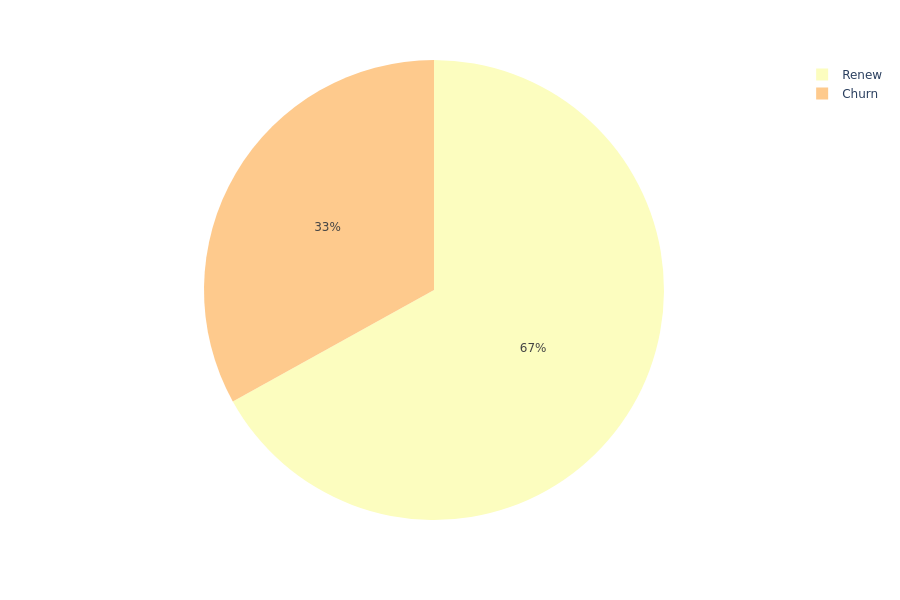

In [75]:
total_churn = round((1-df_subs[['renew']].mean()[0])*100,2)

df_churn_tot = pd.DataFrame(dict({'status':['Churn','Renew'],'value':[total_churn,100-total_churn]}))

fig = px.pie(data_frame=df_churn_tot,values='value', names='status',
             color_discrete_sequence=px.colors.sequential.Magma_r)
fig.show()

A total of 33% of churn is experience for the period 2019 - 2022, for all users. 

### Churn rate by country

The churn rate by continent is shown below, as well as the proportion of users that the country represents. 

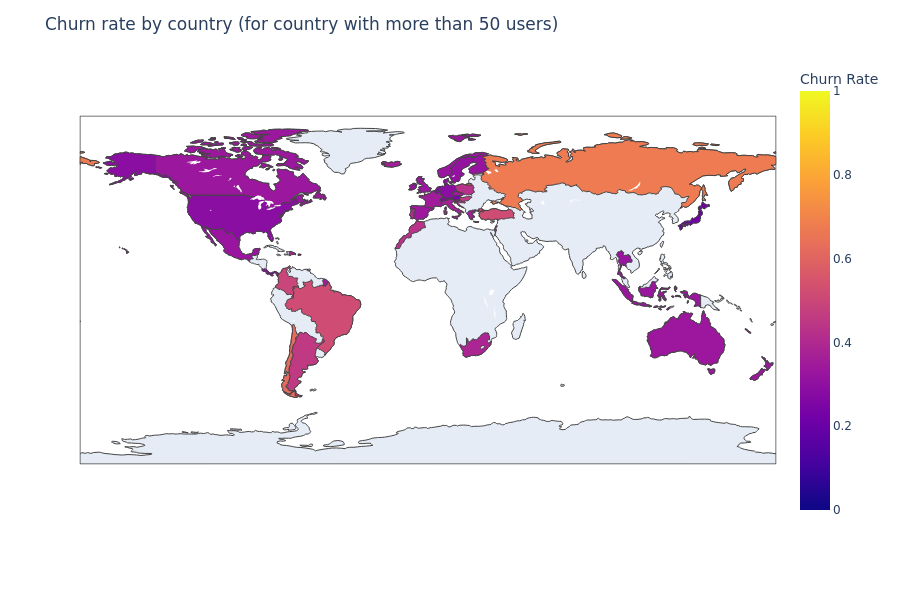

In [76]:
here = df_subs.copy()

here = here.groupby('country').agg({'renew':churn_rate_agg, 'user_id':'count'}).reset_index()
here = here[here.user_id >50]
fig = px.choropleth(here,locations='country',
                         color='renew', hover_name='user_id', hover_data=['user_id'], range_color=[0,1],
                    # marker=dict(opacity=0.1), 
                       )

fig.update_layout(coloraxis_colorbar=dict(title="Churn Rate"))
fig.update_layout(title ="Churn rate by country (for country with more than 50 users)")

fig.show()

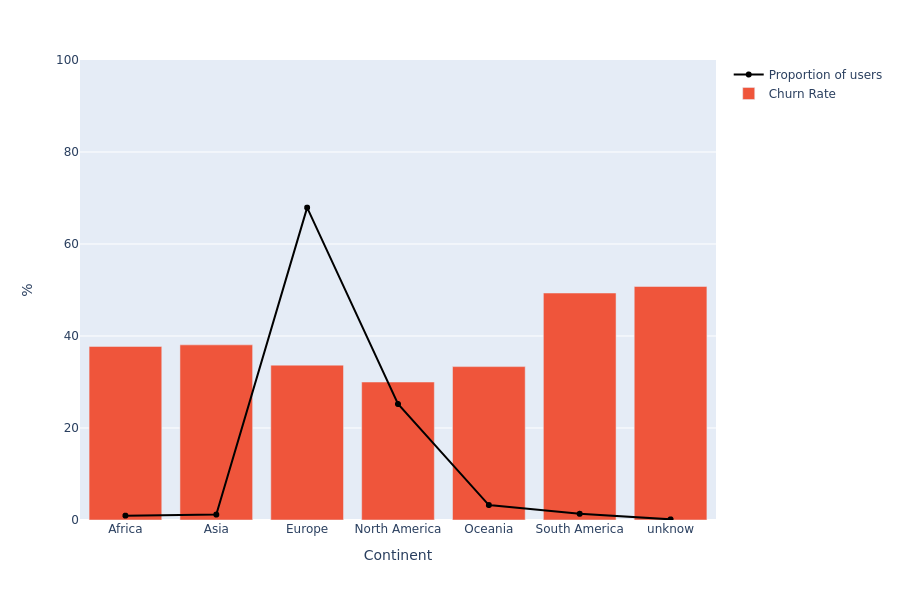

In [77]:

fig = px.line(x=df_subs.groupby('continent').agg({'user_id':'count', 'renew':churn_rate_agg}).reset_index().continent,
              y=df_subs.groupby('continent').agg({'user_id':'count', 'renew':churn_rate_agg}).reset_index().user_id/len(df_subs)*100, 
              range_y=[0,100],
              labels=dict(x="Continent", y="%", color=""),
              color=px.Constant("Proportion of users"),markers=True, )

fig.update_traces(line_color='black', line_width=2)

#px.bar(barmode='group', title ='',range_y=[0,100],)

fig.add_bar(x=df_subs.groupby('continent').agg({'user_id':'count', 'renew':churn_rate_agg}).reset_index().continent,
            y=df_subs.groupby('continent').agg({'user_id':'count', 'renew':churn_rate_agg}).reset_index().renew*100, 
            name='Churn Rate')

fig.update_yaxes(title_text="%")
fig.update_xaxes(title_text="Continent")

fig.show()


    
- In terms of churn rate, South America exhibits the highest rate despite having a relatively low user count. 
- On the other hand, Europe and North America have the largest user bases. 
- Interestingly, Europe has a higher churn rate compared to North America. 
    - **This difference can potentially be attributed to the behavior of North American users, who may subscribe to the platform before finding an exchange or renew their subscriptions without fully utilizing them.**
    - To investigate this further, it is worth considering whether automatic subscription renewal is more prevalent among North American users compared to their European counterparts.
    - To verify this, we can examine the churn rates of users from the USA and France who did not engage in any exchanges throughout the period from 2019 to 2022 :

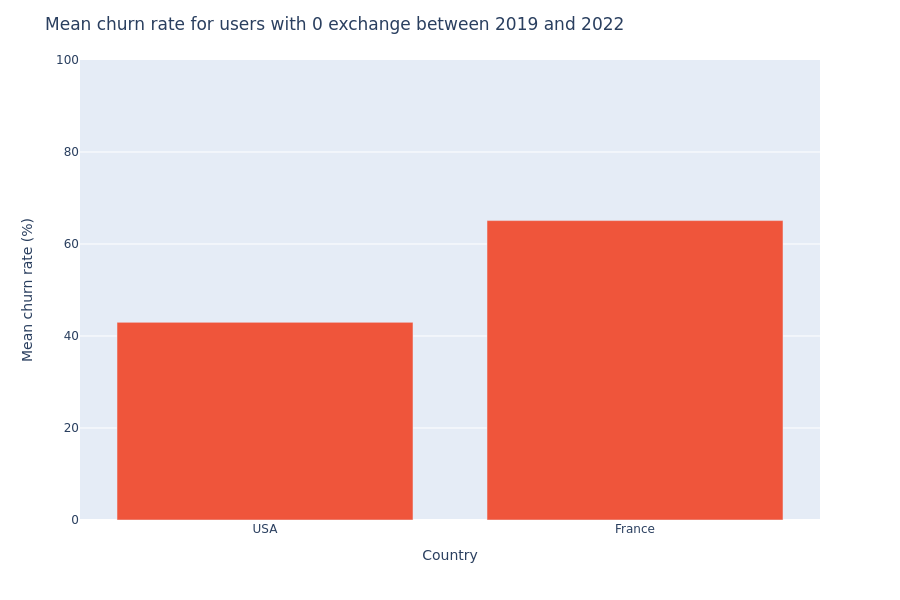

In [78]:
test = df_subscriber[(df_subscriber.country=='USA') & (df_subscriber.total_exchange_done==0)]
usa_churn = np.average(test.mean_churn_rate,weights=test.nb_of_inscription)

test = df_subscriber[(df_subscriber.country=='FRA') & (df_subscriber.total_exchange_done==0)]
french_churn = np.average(test.mean_churn_rate,weights=test.nb_of_inscription)

df= pd.DataFrame(dict({'country':['USA','France'],'mean_churn_rate':[usa_churn, french_churn]}))

fig = px.bar(barmode='group', title ='',range_y=[0,100],)

fig.add_bar(x=df.country,
            y=df.mean_churn_rate*100,
            name='Churn Rate')


fig.update_yaxes(title_text="Mean churn rate (%)")
fig.update_xaxes(title_text="Country")
fig.update_layout(title ="Mean churn rate for users with 0 exchange between 2019 and 2022")

fig.show()

The churn rate for users that did 0 exchange between 2019 and 2022 is much smaller for USA's users compare to French's users, indicating that USA users have more tendency to use automatic renew.

In [79]:
df_subscriber['first_date_exchange'] = df_subscriber['first_date_exchange_as_host_done'].apply(lambda x: pd.to_datetime(x, utc=True).replace(tzinfo=None) if x == 0 else x.replace(tzinfo=None))
df_subscriber['first_subscription_date'] = df_subscriber['first_subscription_date'].apply(lambda x: pd.to_datetime(x, utc=True).replace(tzinfo=None) if x == 0 else x)
df_subscriber['subscription_before_first_exchange'] = np.where(df_subscriber['first_subscription_date']<df_subscriber['first_date_exchange'], 1, 0)


In [80]:
test = df_subscriber[df_subscriber.first_subscription_date>=pd.to_datetime('2019-01-01')]

In [81]:
print('By looking at users that subscribed for the first time after 2019 and that at least 1 exchange : ')
print('- ',round(len(test[(test.country=='USA')& (test.subscription_before_first_exchange==1)& (test.total_exchange_done>0)
                     & (test.nb_of_inscription==1)])/len(test[(test.country=='USA')&(test.nb_of_inscription==1)&(test.total_exchange_done>0)])*100,1), 
    '% of USA users subscribed BEFORE doing any exchange')
print('- ',round(len(test[(test.country=='FRA') &(test.subscription_before_first_exchange==1) & (test.total_exchange_done>0)
               &(test.nb_of_inscription==1)])/len(test[(test.country=='FRA')&(test.nb_of_inscription==1) & (test.total_exchange_done>0)])*100,1),
    '% of French users subscribed BEFORE doing any exchange')


By looking at users that subscribed for the first time after 2019 and that at least 1 exchange : 
-  69.4 % of USA users subscribed BEFORE doing any exchange
-  61.8 % of French users subscribed BEFORE doing any exchange


We can conclude that Americans may tend to take out a subscription before finding an exchange and/or renew without even having taken advantage of their subscription.

## Subscription analysis as function of time

Subscriptions are dependant on time (more subscription for example during official holidays like summer holidays for example).

Besides, data are available for 2019 to 2022, during which COVID and its lockdown strike the world. During this period, as expected, number of subscription decrease and churn rate increase.

/!\ Do not forget than there is one year between the choice of the user to renew or not and the subscription date (that's why the churn rate is shifted by one year compared to subscription count)

Some of the user that leaves during COVID can back after, shown as "return" rate in the following chart.

In [82]:

df_monthly  = df_subs.resample("2W").agg({'user_id': 'count', 'renew':'mean',
                                          'first_subscription':'mean',
                                                'is_zombie':'mean','promotion':'mean'})


In [83]:
df_monthly = df_monthly.rename(columns={"user_id": "subscription_count", 
                                        "renew": "churn_percentage", 
                                        "is_zombie":"return_percentage"})



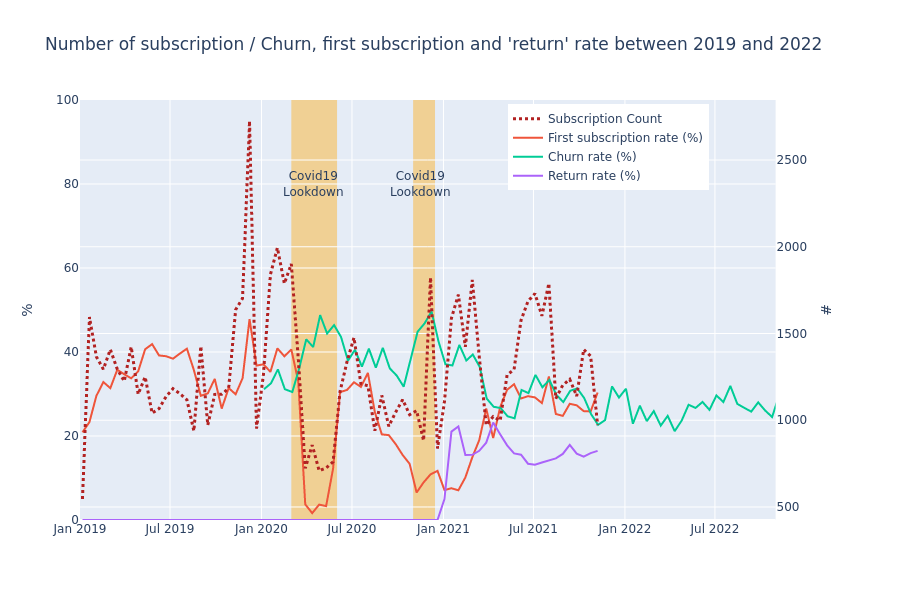

In [84]:
# Create figure with secondary y-axis
fig2 = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig2.add_trace(
    go.Scatter(x=df_monthly.index, y=df_monthly.subscription_count, 
               name="Subscription Count",
               line = dict(color='firebrick', width=3, dash='dot')),
    secondary_y=True,
)

fig2.add_trace(
    go.Scatter(x=df_monthly.index,
               y=(df_monthly.first_subscription)*100, name="First subscription rate (%)"))


fig2.add_trace(
    go.Scatter(x=df_monthly.index+pd.offsets.DateOffset(years=1),
               y=(1-df_monthly.churn_percentage)*100 , name="Churn rate (%)"),)

fig2.add_trace(
    go.Scatter(x=df_monthly.index,
               y=(df_monthly.return_percentage)*100 , name="Return rate (%)"),)



# Set y-axes titles

fig2.update_yaxes(range=[0,100], secondary_y=False)
fig.update_xaxes(range=[min(df_subs.index),max(df_subs.index)+pd.offsets.DateOffset(years=1)])
fig2.update_xaxes(range=[min(df_subs.index),max(df_subs.index)+pd.offsets.DateOffset(years=1)])

# specify the corners of the rectangles
covid_range = [dict(type="rect", xref="x", yref="y",
         x0="2020-03-01",y0="0",x1="2020-06-01",y1="5000",
         fillcolor="orange",opacity=0.4,line_width=0,layer="below"),
               dict(type="rect", xref="x", yref="y",
         x0="2020-11-01",y0="0",x1="2020-12-15",y1="5000",
         fillcolor="orange",opacity=0.4,line_width=0,layer="below") ]

covid_label = f"<br>".join([f"Covid19",f"Lookdown"])

fig2.update_layout(shapes=covid_range)



fig2.add_annotation(x="2020-04-15", y=80,  showarrow=False,
                        text=covid_label )
fig2.add_annotation(x="2020-11-15", y=80,  showarrow=False,
                        text=covid_label)

fig2.update_layout(legend=dict( yanchor="top", y=0.99,xanchor="right",x=0.85))

fig2.update_yaxes(title_text="%", secondary_y=False)
fig2.update_yaxes(title_text="#", secondary_y=True)


fig2.update_layout(title ="Number of subscription / Churn, first subscription and 'return' rate between 2019 and 2022")


fig2.show()



COVID is showing a large impact on churn rate, which can be verified with a statistical test (Fisher exact in this case). 

COVID is for the period before 2021-04-15 and POST-COVID is for period after this date

In [85]:
df_subs['covid_subs'] = np.where(df_subs.index >=pd.to_datetime('2021-04-15'),
                                 '1_post-covid','0_covid')

In [86]:
df_subs['covid_renew'] = np.where(df_subs.index +pd.offsets.DateOffset(years=1)>=pd.to_datetime('2021-04-15'), 
                                  '1_post-covid','0_covid')
tab = pd.crosstab(df_subs.covid_renew,df_subs.renew)
tab

renew,0,1
covid_renew,,
0_covid,17595,27334
1_post-covid,14015,36686


In [87]:
import scipy.stats as stats
# CONDUCT FISHER_EXACT STATISTICAL TEST
odds_ratio, p_value = stats.fisher_exact(tab)

In [88]:
# PRINT OUT RESULTS
if p_value < 0.05:
    print(f'p_value: {p_value}\nResult: There is a significant difference between PRE-COVID and POST-COVID period')
else:
    print(f'p_value: {p_value}\nResult: No significant difference')

p_value: 1.23418038102e-312
Result: There is a significant difference between PRE-COVID and POST-COVID period


In [89]:
# # chi2 
# chiRes = stats.chi2_contingency(tab)
# p_value = chiRes[1]
# if p_value < 0.05:
#     print(f'p_value: {p_value}\nResult: There is a significant difference')
# else:
#     print(f'p_value: {p_value}\nResult: No significant difference')

**This impact will be keep in mind for the rest of the analysis.**

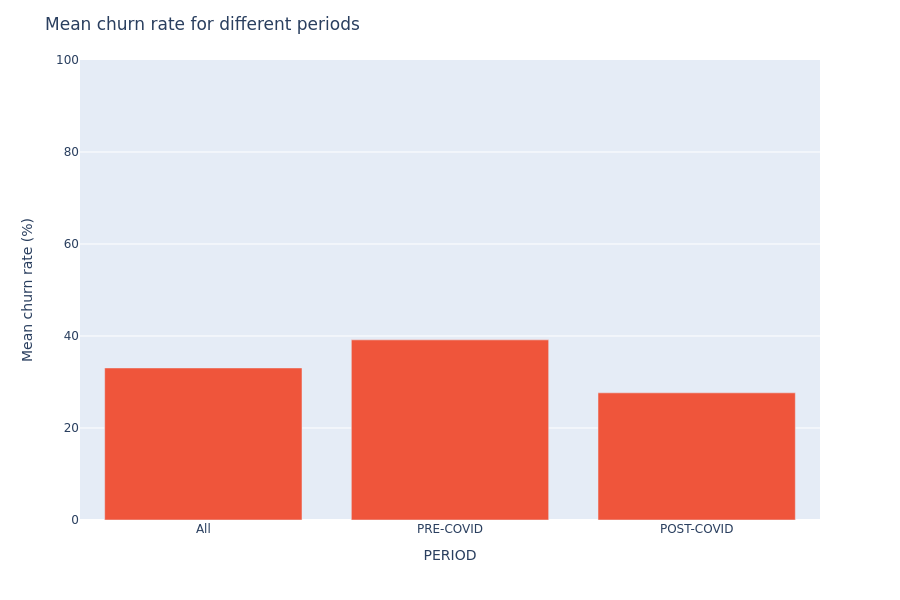

In [90]:
df_subs_post_covid = df_subs[df_subs.covid_renew=='1_post-covid']
df_subs_pre_covid = df_subs[df_subs.covid_renew!='1_post-covid']
fig = px.bar(barmode='group', range_y=[0,100])

fig.add_bar(x=['All', 'PRE-COVID','POST-COVID'],y=[100-df_subs.renew.mean()*100,
                                               100-df_subs_pre_covid.renew.mean()*100,
                                               100-df_subs_post_covid.renew.mean()*100])


fig.update_yaxes(title_text="Mean churn rate (%)")
fig.update_xaxes(title_text="PERIOD")
fig.update_layout(title ="Mean churn rate for different periods")

fig.show()

## Churn rate as a function of user caracteristics 

The churn rate as a function of the user caracteristics is important to understand why users are leaving

### Is it the first subsription of the user ? 

In this case, COVID can have a real impact

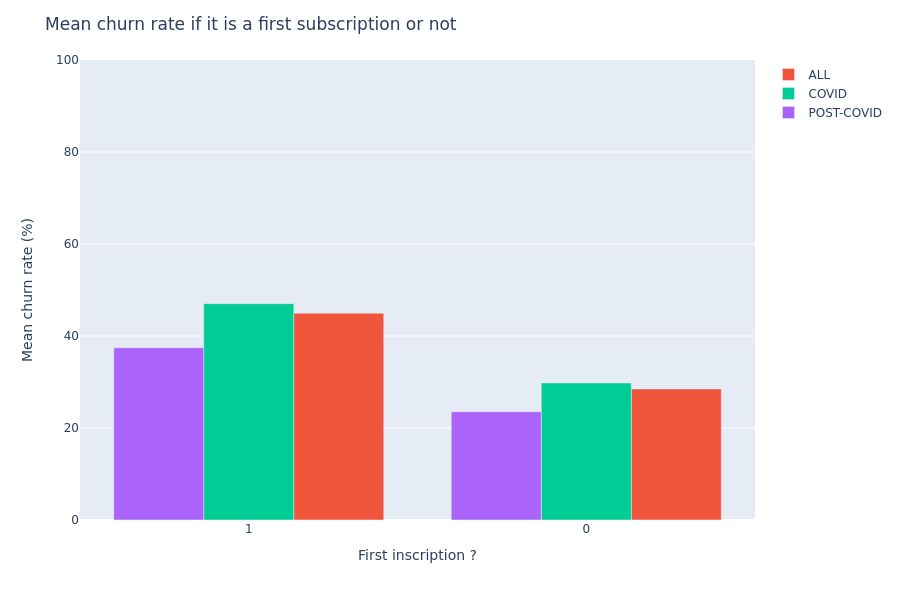

In [94]:
df_subs_post_covid = df_subs[df_subs.covid_subs=='1_post-covid']
df_subs_pre_covid = df_subs[df_subs.covid_subs!='1_post-covid']


fig = px.bar(barmode='group', range_y=[0,100])
fig.add_bar(x=df_subs.groupby('first_subscription').agg({'user_id': 'count', 'renew':churn_rate_agg}).reset_index().first_subscription,
           y=100*df_subs.groupby('first_subscription').agg({'user_id': 'count', 
                                                 'renew':churn_rate_agg}).reset_index().renew,name='ALL')

fig.add_bar(x=df_subs_pre_covid.groupby('first_subscription').agg({'user_id':  'count', 'renew':churn_rate_agg}).reset_index().first_subscription,
             y=100*df_subs_pre_covid.groupby('first_subscription').agg({'user_id':  'count', 'renew':churn_rate_agg}).reset_index().renew,
           name='COVID')
fig.add_bar(x=df_subs_post_covid.groupby('first_subscription').agg({'user_id':  'count', 'renew':churn_rate_agg}).reset_index().first_subscription,
             y=100*df_subs_post_covid.groupby('first_subscription').agg({'user_id':  'count', 'renew':churn_rate_agg}).reset_index().renew,
           name='POST-COVID')

fig.update_layout(xaxis=dict(autorange="reversed"))

            
fig.update_yaxes(title_text="Mean churn rate (%)")
fig.update_xaxes(title_text="First inscription ?")

fig.update_layout(title ="Mean churn rate if it is a first subscription or not")


fig.show()


As expected, the churn rate is smaller for user that did subscribe before (not a first subscription).
Besides, if the first subscription was done before or during COVID, then the churn rate is larger than if it was done after COVID (after 2021-06-15), which is perfectly normal since user had more difficulty to travel 


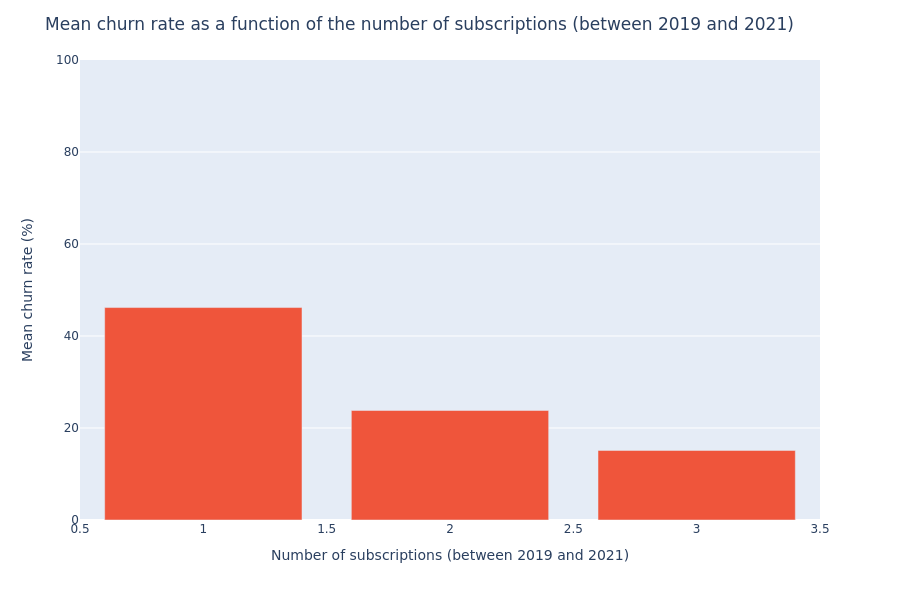

In [62]:

test= df_subs.groupby('user_id').agg({'pk':'count', 'renew':churn_rate_agg})
fig = px.bar(barmode='group',range_y=[0,100])

fig.add_bar(x=test.groupby('pk').agg({'renew':'mean'}).reset_index().pk
            ,y=100*test.groupby('pk').agg({'renew':'mean'}).reset_index().renew)


fig.update_yaxes(title_text="Mean churn rate (%)")
fig.update_xaxes(title_text="Number of subscriptions (between 2019 and 2021)")
fig.update_layout(title ="Mean churn rate as a function of the number of subscriptions (between 2019 and 2021)")

As expected, the more the users subscribed in the past, the less they leave during the following year. That means that, when the solution is working (managed to travel), user stay and continue to use it (it can also be automatic renew in case of user that don't travel, see after)

### Use of promotion


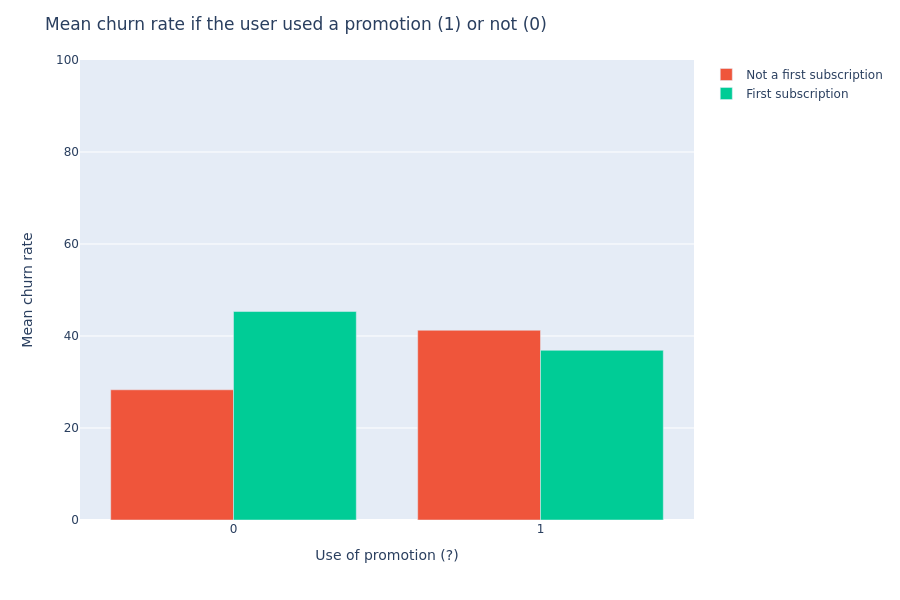

In [95]:
# note: different impact if the promotion was taken at the first subscription or not
test= df_subs[df_subs.first_subscription==0]

fig = px.bar(barmode='group', range_y=[0,100])

fig.add_bar(x=test.groupby('promotion').agg({'renew':churn_rate_agg}).reset_index().promotion
            ,y=100*test.groupby('promotion').agg({'renew':churn_rate_agg}).reset_index().renew,
            name='Not a first subscription')


# note: different impact if the promotion was taken at the first subscription or not
test= df_subs[df_subs.first_subscription==1]

fig.add_bar(x=test.groupby('promotion').agg({'renew':churn_rate_agg}).reset_index().promotion
            ,y=100*test.groupby('promotion').agg({'renew':churn_rate_agg}).reset_index().renew,name='First subscription')

fig.update_yaxes(title_text="Mean churn rate")
fig.update_xaxes(title_text="Use of promotion (?)")
fig.update_layout(title ="Mean churn rate if the user used a promotion (1) or not (0)")
            

If a user utilizes a promotional offer for their initial subscription, their likelihood of remaining on the platform is higher compared to those who did not use a promotion. However, the scenario is reversed when a user avails a promotion for a subsequent subscription. In such cases, the churn rate increases from 28% to 41% compared to those who did not use a promotion.

### Referral

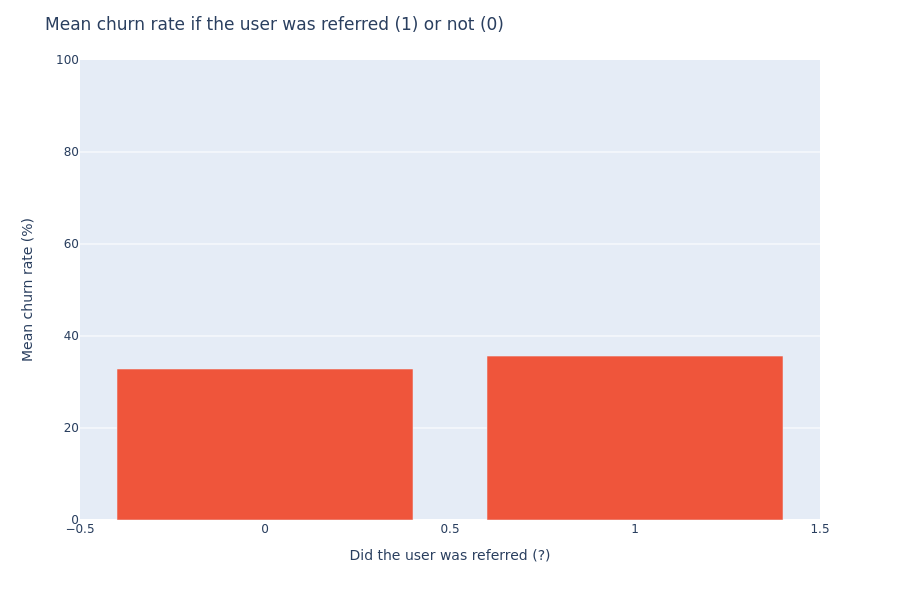

In [96]:

test= df_subs
fig = px.bar(barmode='group', range_y=[0,100])

fig.add_bar(x=test.groupby('referral').agg({'renew':churn_rate_agg}).reset_index().referral
            ,y=100*test.groupby('referral').agg({'renew':churn_rate_agg}).reset_index().renew,name='total')

    
fig.update_yaxes(title_text="Mean churn rate (%)")
fig.update_xaxes(title_text="Did the user was referred (?)")
fig.update_layout(title ="Mean churn rate if the user was referred (1) or not (0)")
          

Referral do not impact much the churn rate

# Exchange Table

In the previous section, we have studied subscription and users' characteristics. One other interesting feature to study is the exchange type and number as a function of time.

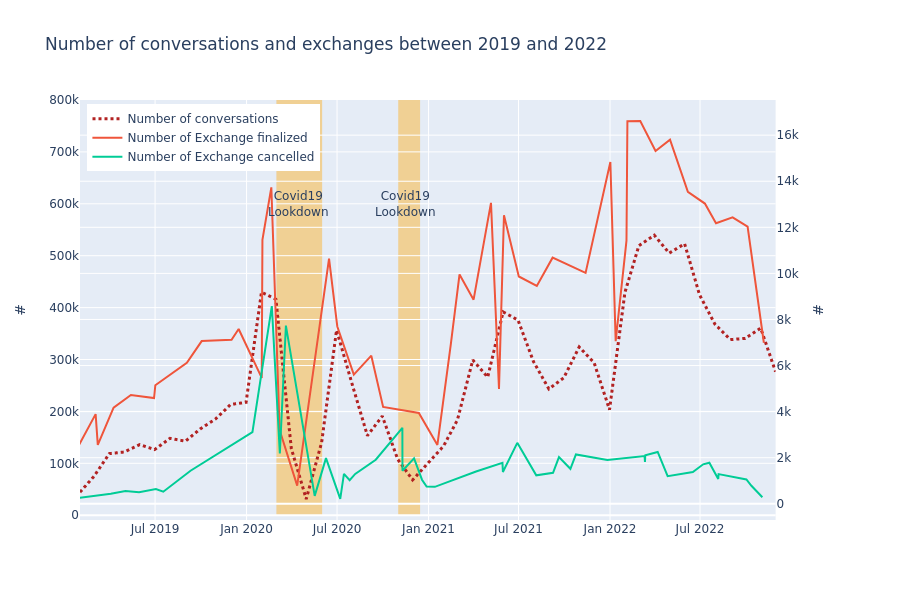

In [97]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_exc_monthly.index, y=df_exc_monthly.exchange_id_count, 
               name="Number of conversations",
               line = dict(color='firebrick', width=3, dash='dot')),
    secondary_y=False,
)


# Add traces
fig.add_trace(
    go.Scatter(x=df_exc_monthly.set_index('finalized_at_first').sort_index().index, 
               y=df_exc_monthly.set_index('finalized_at_first').sort_index().finalized_at_count, 
               name="Number of Exchange finalized", ),
    secondary_y=True,
)

# Add traces
fig.add_trace(
    go.Scatter(x=df_exc_monthly.set_index('canceled_at_first').sort_index().index, 
               y=df_exc_monthly.set_index('canceled_at_first').sort_index().canceled_at_count, 
               name="Number of Exchange cancelled", 
             ),
    secondary_y=True,
)


# Set y-axes titles
fig.update_yaxes(title_text="#", secondary_y=False)
fig.update_xaxes(range=[min(df_exc_monthly.index),max(df_exc_monthly.index)])

# specify the corners of the rectangles
covid_range = [dict(type="rect", xref="x", yref="y",
         x0="2020-03-01",y0="0",x1="2020-06-01",y1="800000",
         fillcolor="orange",opacity=0.4,line_width=0,layer="below"),
               dict(type="rect", xref="x", yref="y",
         x0="2020-11-01",y0="0",x1="2020-12-15",y1="800000",
         fillcolor="orange",opacity=0.4,line_width=0,layer="below") ]

covid_label = f"<br>".join([f"Covid19",f"Lookdown"])

fig.update_layout(shapes=covid_range)

fig.add_annotation(x="2020-04-15", y=600000,  showarrow=False,
                        text=covid_label )
fig.add_annotation(x="2020-11-15", y=600000,  showarrow=False,
                        text=covid_label)
fig.update_yaxes(title_text="#")
fig.update_layout(title ="Number of conversations and exchanges between 2019 and 2022")

fig.update_layout(legend=dict( yanchor="top", y=0.99,xanchor="left",x=0.01))

fig.show()


As expected, during look down, a lot of exchange were canceled as users could not travel. In the same way, the number of conversation and exchange finalizes during COVID period drastically drops. 

However, something interesting appears on this graph: the amount of exchange increase after COVID (compare to the period before the first look down). Since the number of inscriptions (see section 3) did not increase that much after COVID, that indicate that users that already subscribed travel more after COVID! 
There is alsmot 3 (2.97) times more exchange finalized in June 2021 compared to June 2019, while there are only 1.48 more users that subscribed (including renewals). 

(Exchanges : JUNE 2021:  375 865 vs JUNE 2019: 126 410)	
Subscriptions : JUNE 2021 : 3 262 vs JUNE 2019 : 2 203)

<span style="color:red">**People travel more, that means that those users should be happier with the solution and could be the ambassador for Home Exchange. It could be interesting to increase reward for users that recommended the solution to friends.**</span>.

# Users Analysis

Based on both Subcription and Exchange tables, we want to study the travel comportment of users that subscribe to the solution.


First, it is interesting to see that the number of users that registered but not subscribed is important. 


Then, the impact of the number of exchanges and the typology of the users (if they are a guest or host, or both) on the churn rate will be studied. 

NB: each user can leave or not several years, which give a mean churn rate by user. To calculate the "total" mean churn rate (calculated by the number of subscriptions and not by number of users), the mean churn rate will be calculated as a weighted average of the mean churn rate per user (weighted by the number of inscriptions of the user).


## Register users that never subscribed to the solution

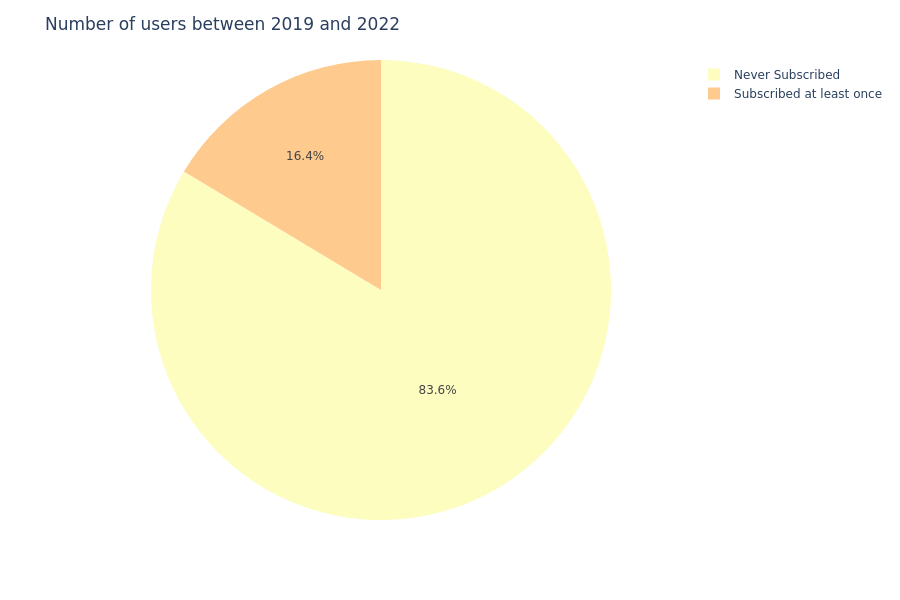

In [98]:

pie_df = pd.DataFrame(dict({'status':['Never Subscribed','Subscribed at least once'],
                            'value':[len(df_non_subscriber),len(df_subscriber)]}))

fig =px.pie(data_frame=pie_df,values='value', names='status',color_discrete_sequence=px.colors.sequential.Magma_r, 
      )

fig.update_layout(title ="Number of users between 2019 and 2022")


Almost 84% of registered users never subscribed to the solution.

It is an important number but not really surprising considering the solution offered by HomeExchange. 

We can quickly study the comportement of users that did not subscribed by determine the number of conversation those users did (meaning the number of time they try to find an exchange) : 



In [99]:
df_here = df_non_subscriber[['user_id','country',
                             'nb_of_conversation_as_host',
                             'nb_of_conversation_as_guest',
                             'nb_of_conversation_for_exchange']].reset_index()
df_here['conv_tot']=df_here['nb_of_conversation_as_host']+df_here['nb_of_conversation_as_guest']+df_here['nb_of_conversation_for_exchange']
df_here=df_here[['user_id','country','conv_tot']]



In [100]:
def demi_vie(x,C0,l,C1):
    return C0*np.exp(-l*x)+C1

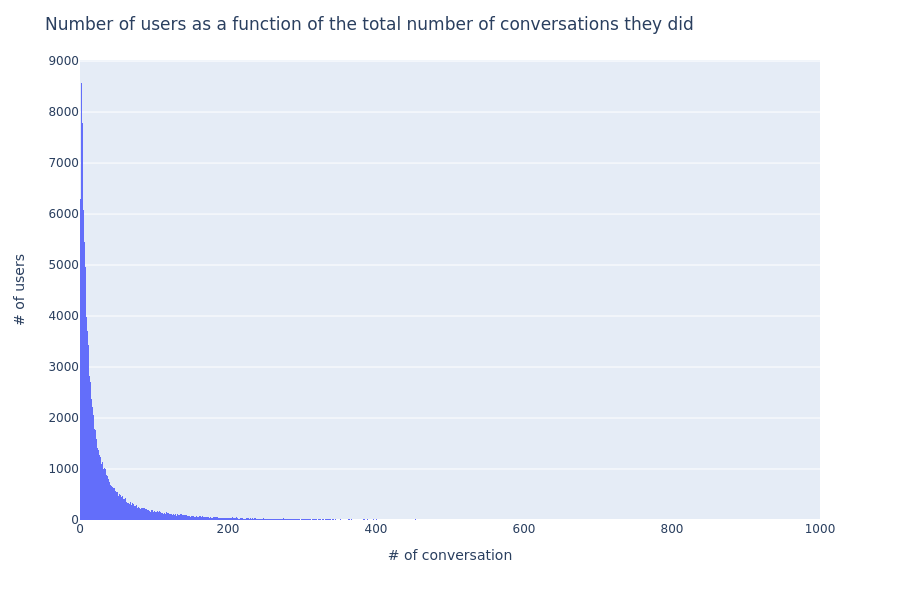

In [101]:

fig = px.histogram(data_frame=df_here,x='conv_tot', y='user_id', log_y=False, range_x=[0,1000], histfunc='count')
fig.update_layout(title ="Number of users as a function of the total number of conversations they did")
fig.update_yaxes(title_text="# of users")
fig.update_xaxes(title_text="# of conversation")



fig.show()

The number of conversations follows a decreasing exponential function. It is possible to estimate the number of conversations after which half of the users "disappear" (meaning that half of the initial users are not trying to find exchange after this number). 

To do this, we can do a fit with a half-life functional:

Number of conversation for which the total number of users (that did not subscribed) reduce to half of its initial value is  8.9


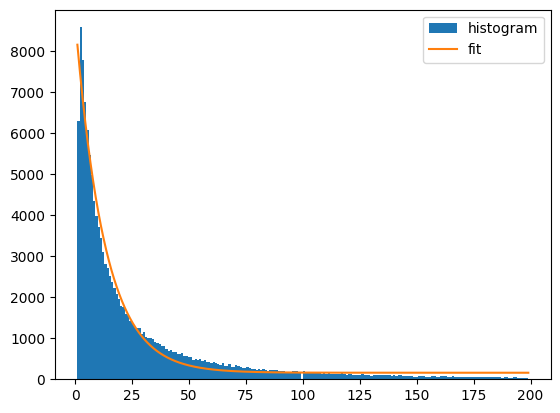

In [102]:
from scipy.optimize import curve_fit

bin_heights, bin_borders, _ = plt.hist(df_here[df_here.conv_tot<200].conv_tot, bins=200, label='histogram')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(demi_vie, bin_centers, bin_heights, p0=[15000, 0.07, 500])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, demi_vie(x_interval_for_fit, *popt), label='fit')
plt.legend()
print('Number of conversation for which the total number of users (that did not subscribed) reduce to half of its initial value is ', round(np.log(2)/popt[1],1))

After 9 conversations, half of the users are not trying to find exchange anymore. 

It could be interesting to study in more depth why users to not subscribed, but it will not be done here as we are interested by the churn rate.

## Subscribed user

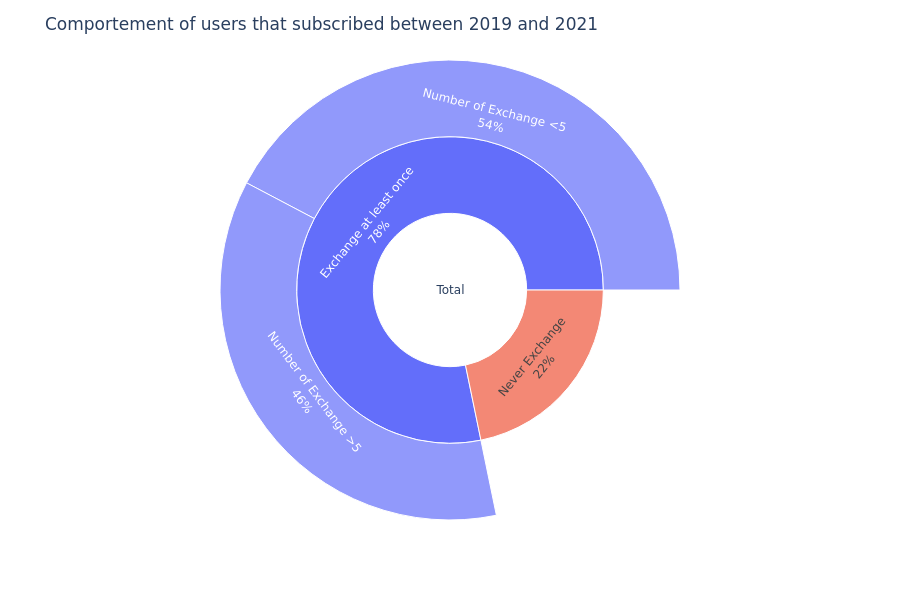

In [103]:
data = dict(status=['Total','Never Exchange','Exchange at least once',
                    'Number of Exchange <5','Number of Exchange >5'],
            parent=['','Total','Total',
                    'Exchange at least once',
                    'Exchange at least once'],
            value=[len(df_subscriber), 
                     len(df_subscriber[df_subscriber.total_exchange_done==0]),
                     len(df_subscriber[df_subscriber.total_exchange_done>0]),
                     len(df_subscriber[(df_subscriber.total_exchange_done>=1)&
                                       (df_subscriber.total_exchange_done<=5)]),
                     len(df_subscriber[(df_subscriber.total_exchange_done>5)]),
                  ])

fig = px.sunburst(
    data,
    names='status',
    parents='parent',
    values='value', 
     branchvalues='total'

)

fig.update_traces(textinfo="label + percent parent")

fig.update_layout(title ="Comportement of users that subscribed between 2019 and 2021")

fig.show()

  - 78% of users that susbcribed between 2019 and 2021 did at least one exchange, and 46% of those users did more than 5 exchanges between 2019 and 2022. 

  - 22 % of users that subscribed between 2019 and 2021 did not use the solution at all. As expected, those users have a large mean churn rate equals to 51.5% as shown on the next chart : 

In [104]:

df_subscriber_first_covid= df_subscriber[(df_subscriber.first_subscription_date<pd.to_datetime('2021-06-01'))
                                         &(df_subscriber.first_subscription_date==df_subscriber.last_subscription_date)]
df_subscriber_first_postcovid= df_subscriber[(df_subscriber.first_subscription_date>=pd.to_datetime('2021-06-01'))
                                        &(df_subscriber.first_subscription_date==df_subscriber.last_subscription_date)]

df_subscriber_first_only_host_covid= df_subscriber_only_host[(df_subscriber_only_host.first_subscription_date<pd.to_datetime('2021-06-01'))
                                         &(df_subscriber_only_host.first_subscription_date==df_subscriber_only_host.last_subscription_date)]
df_subscriber_first_only_host_postcovid= df_subscriber_only_host[(df_subscriber_only_host.first_subscription_date>=pd.to_datetime('2021-06-01'))
                                        &(df_subscriber_only_host.first_subscription_date==df_subscriber_only_host.last_subscription_date)]

df_subscriber_first_only_guest_covid= df_subscriber_only_guest[(df_subscriber_only_guest.first_subscription_date<pd.to_datetime('2021-06-01'))
                                         &(df_subscriber_only_guest.first_subscription_date==df_subscriber_only_guest.last_subscription_date)]
df_subscriber_first_only_guest_postcovid= df_subscriber_only_guest[(df_subscriber_only_guest.first_subscription_date>=pd.to_datetime('2021-06-01'))
                                        &(df_subscriber_only_guest.first_subscription_date==df_subscriber_only_guest.last_subscription_date)]

df_subscriber_first_none_covid= df_subscriber_none[(df_subscriber_none.first_subscription_date<pd.to_datetime('2021-06-01'))
                                         &(df_subscriber_none.first_subscription_date==df_subscriber_none.last_subscription_date)]
df_subscriber_first_none_postcovid= df_subscriber_none[(df_subscriber_none.first_subscription_date>=pd.to_datetime('2021-06-01'))
                                        &(df_subscriber_none.first_subscription_date==df_subscriber_none.last_subscription_date)]

df_subscriber_first_both_covid= df_subscriber_both[(df_subscriber_both.first_subscription_date<pd.to_datetime('2021-06-01'))
                                         &(df_subscriber_both.first_subscription_date==df_subscriber_both.last_subscription_date)]
df_subscriber_first_both_postcovid= df_subscriber_both[(df_subscriber_both.first_subscription_date>=pd.to_datetime('2021-06-01'))
                                        &(df_subscriber_both.first_subscription_date==df_subscriber_both.last_subscription_date)]



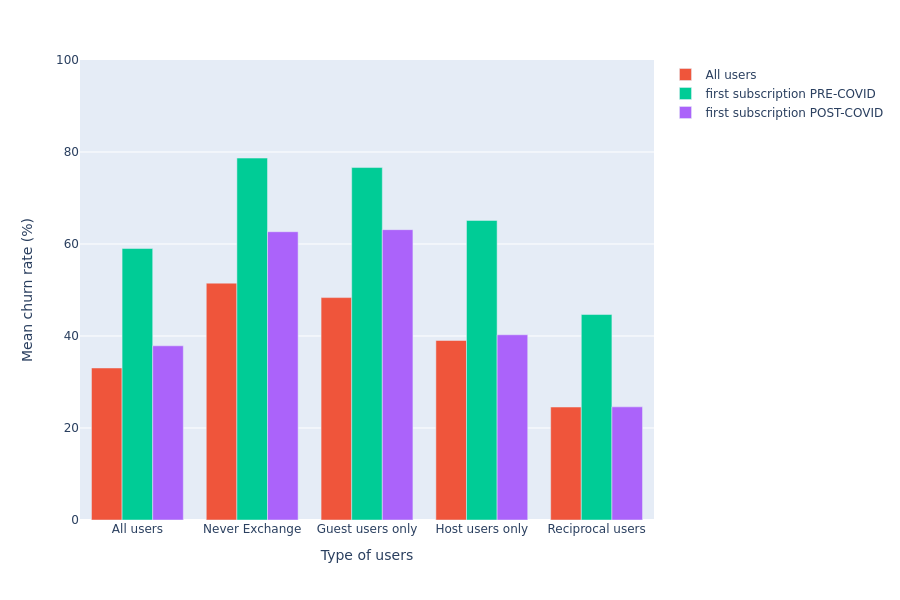

In [109]:

fig = px.bar(range_y=[0,100], barmode='group')




bar_df = pd.DataFrame(dict({'status':['All users',
                                      'Never Exchange',
                                      'Guest users only',
                                      'Host users only',
                                      'Reciprocal users'],
                            'value':[round(np.average(df_subscriber.mean_churn_rate, 
                                                      weights=df_subscriber.nb_of_inscription)*100,2), 
                                     round(np.average(df_subscriber_none.mean_churn_rate,
                                                      weights=df_subscriber_none.nb_of_inscription)*100,2),
                                    round(np.average(df_subscriber_only_guest.mean_churn_rate, 
                                                     weights=df_subscriber_only_guest.nb_of_inscription)*100,2), 
                                    round(np.average(df_subscriber_only_host.mean_churn_rate, 
                                                     weights=df_subscriber_only_host.nb_of_inscription)*100,2), 
                                     round(np.average(df_subscriber_both.mean_churn_rate, 
                                                      weights=df_subscriber_both.nb_of_inscription)*100,2)]}))

fig.add_bar(x=bar_df['status'], y=bar_df['value'], name='All users')
            
    

# if first inscription avant covid
bar_df = pd.DataFrame(dict({'status':['All users',
                                      'Never Exchange',
                                      'Guest users only',
                                      'Host users only',
                                      'Reciprocal users'],
                            'value':[np.average(df_subscriber_first_covid.mean_churn_rate,
                                                weights=df_subscriber_first_covid.nb_of_inscription)*100,
                                     np.average(df_subscriber_first_none_covid.mean_churn_rate,
                                                weights=df_subscriber_first_none_covid.nb_of_inscription)*100,
                                     np.average(df_subscriber_first_only_guest_covid.mean_churn_rate,
                                                weights=df_subscriber_first_only_guest_covid.nb_of_inscription)*100,
                                     np.average(df_subscriber_first_only_host_covid.mean_churn_rate,
                                                weights=df_subscriber_first_only_host_covid.nb_of_inscription)*100,
                                     np.average(df_subscriber_first_both_covid.mean_churn_rate,
                                                weights=df_subscriber_first_both_covid.nb_of_inscription)*100
                                    ],
                           'data_size':[len(df_subscriber_first_covid),
                                        len(df_subscriber_first_none_covid),
                                        len(df_subscriber_first_only_guest_covid),
                                        len(df_subscriber_first_only_host_covid),
                                        len(df_subscriber_first_both_covid)]}))
                            
fig.add_bar(x=bar_df['status'], y=bar_df['value'], name='first subscription PRE-COVID')
# fig.add_traces(go.Scatter(x=bar_df['status'], y=bar_df['value'], line_color='rgba(0, 152, 0, .8)',
#                           mode = 'lines',name='# of first subscription (COVID)'))




# if first inscription après covid
bar_df = pd.DataFrame(dict({'status':['All users',
                                      'Never Exchange',
                                      'Guest users only',
                                      'Host users only',
                                      'Reciprocal users'],
                            'value':[np.average(df_subscriber_first_postcovid.mean_churn_rate,
                                                weights=df_subscriber_first_postcovid.nb_of_inscription)*100,
                                     np.average(df_subscriber_first_none_postcovid.mean_churn_rate,
                                                weights=df_subscriber_first_none_postcovid.nb_of_inscription)*100,
                                     np.average(df_subscriber_first_only_guest_postcovid.mean_churn_rate,
                                                weights=df_subscriber_first_only_guest_postcovid.nb_of_inscription)*100,
                                     np.average(df_subscriber_first_only_host_postcovid.mean_churn_rate,
                                                weights=df_subscriber_first_only_host_postcovid.nb_of_inscription)*100,
                                     np.average(df_subscriber_first_both_postcovid.mean_churn_rate,
                                                weights=df_subscriber_first_both_postcovid.nb_of_inscription)*100
                                    ],
                           'data_size':[len(df_subscriber_first_postcovid),
                                        len(df_subscriber_first_none_postcovid),
                                        len(df_subscriber_first_only_guest_postcovid),
                                        len(df_subscriber_first_only_host_postcovid),
                                        len(df_subscriber_first_both_postcovid)]}))
                            
fig.add_bar(x=bar_df['status'], y=bar_df['value'], name='first subscription POST-COVID')
#fig.add_traces(go.Scatter(x=bar_df['status'], 
#                          y=bar_df['value'], mode = 'lines', line_color='rgba(152, 0, 0, .8)',
#                          name='# of first subscription (POSTCOVID)'))

fig.update_yaxes(title_text="Mean churn rate (%)")
fig.update_xaxes(title_text="Type of users")
fig.show()


The use of Guest Point (guest only) does not allow to convince users to stay another year especially for first subscriber (even after COVID).


On the other hand, if users do exchange their houses, even for a first subscription, they have a much smaller churn rate! 


**This is the solution that is working !**

To go futher, we can study the comportement of users that do not travel thanks to HomeExchange. As for users that never subscribed, we can find how many times (i.e. how many conversation) a users that do not managed to travel thanks to HomeExchange did : 

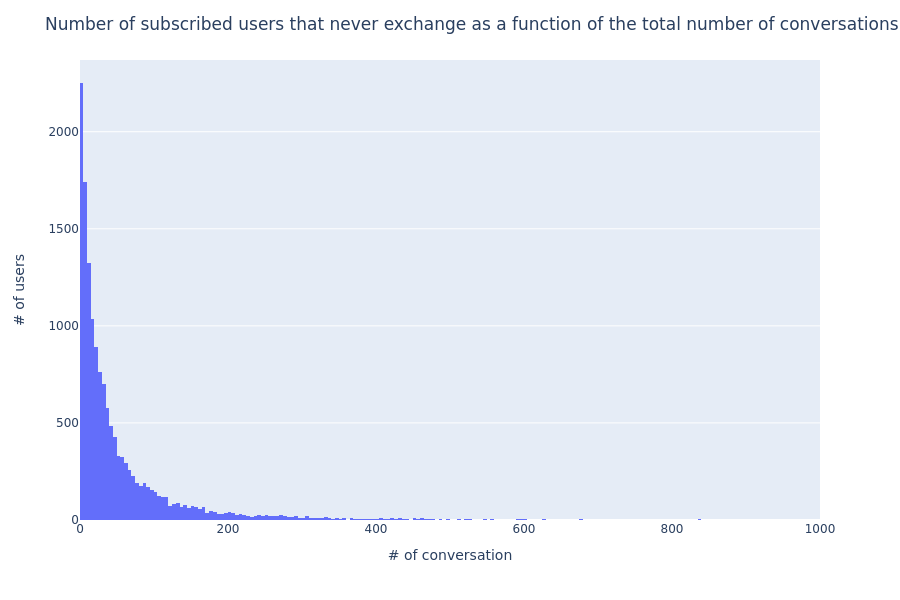

In [106]:
df_subscriber_none['conv_tot'] =df_subscriber_none['nb_of_conversation_as_guest'] + df_subscriber_none['nb_of_conversation_for_exchange'] + df_subscriber_none['nb_of_conversation_as_host']
df_here = df_subscriber_none[['user_id','conv_tot']]
fig = px.histogram(data_frame=df_here,y='user_id',x='conv_tot', log_y=False, range_x=[0,1000], histfunc='count')
fig.update_layout(title ="Number of subscribed users that never exchange as a function of the total number of conversations")
fig.update_yaxes(title_text="# of users")
fig.update_xaxes(title_text="# of conversation")

fig.show()


The number of conversations follows a decreasing exponential function. It is possible to estimate the number of conversations after which half of the users "disappear" (meaning that half of the initial users are not trying to find exchange after this number). 



To do this, we can do a fit with a half-life function: 


Number of conversation for which the total number of users (that did not exchange) reduce to half of its initial value : 12.5


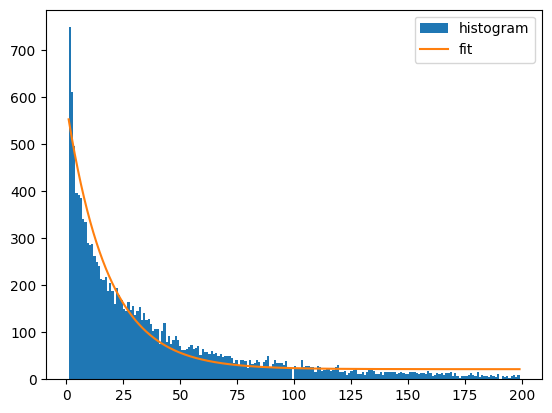

In [107]:

bin_heights, bin_borders, _ = plt.hist(df_here[df_here.conv_tot<200].conv_tot, bins=200, label='histogram')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(demi_vie, bin_centers, bin_heights, p0=[1500, 0.07, 500])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, demi_vie(x_interval_for_fit, *popt), label='fit')
plt.legend()
print('Number of conversation for which the total number of users (that did not exchange) reduce to half of its initial value :', round(np.log(2)/popt[1],1))

After 9 conversations, half of the users are not trying to find exchange anymore.

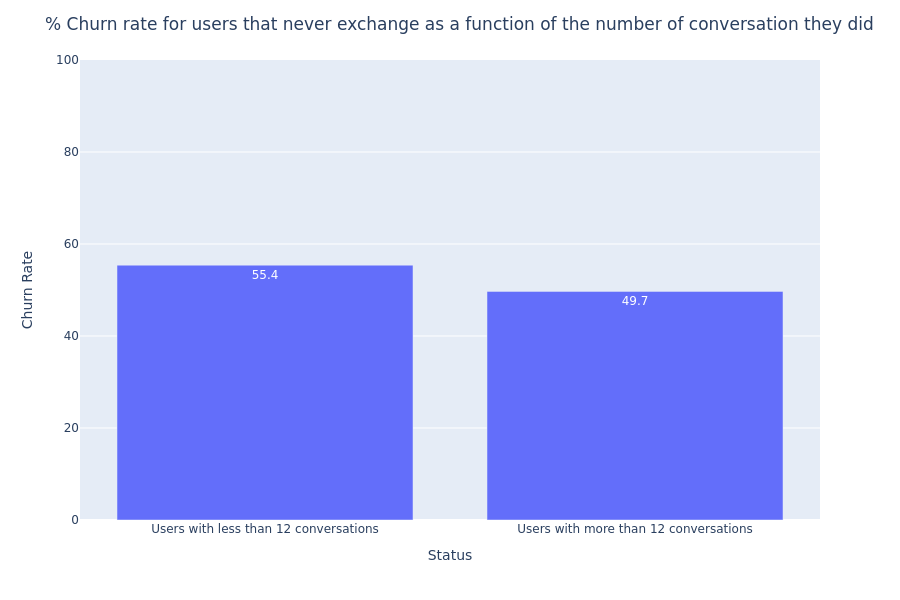

In [108]:

pie_df = pd.DataFrame(dict({'Status':['Users with less than 12 conversations',
                                      'Users with more than 12 conversations'],
                            'Churn Rate':[round(100*np.average(df_subscriber_none[df_subscriber_none['conv_tot']<=12.5].mean_churn_rate, 
                                                         weights=df_subscriber_none[df_subscriber_none['conv_tot']<=12.5].nb_of_inscription),1),
                                          round(100*np.average(df_subscriber_none[df_subscriber_none['conv_tot']>12.5].mean_churn_rate, 
                                                weights=df_subscriber_none[df_subscriber_none['conv_tot']>12.5].nb_of_inscription),1),
                            ]}))

fig =px.bar(data_frame=pie_df,y='Churn Rate', x='Status', range_y=[0,100],text_auto=True)

fig.update_layout(title ="% Churn rate for users that never exchange as a function of the number of conversation they did")


Users that never exchanges and did less than 12 conversations have a largest churn rate than those who did more than 12 conversations. That behavior indicated that the churner are those who do not try a lot to find an exchange.

   
<span style="color:red">**Maybye HomeExchange could try to motivate them with some e-mails or recommendations (for example improve quality of house picture or description, alert when users city is on the top research on the web site etc...)**</span> 

# Recommendations

To optimize user engagement and improve the HomeExchange platform, the following strategies can be implemented:

- **Identify highly active users to serve as ambassadors**
    - Enhance user profiles by including social media information.
    - Utilize ambassadors to promote the platform and engage with the community.
    - Recognize and reward users who successfully refer a significant number of new users.
- **Enhancing Reciprocal Exchanges:**
    - Encourage reciprocal exchanges by offering advantages or exclusive features to users participating in such exchanges.
    - Increase the visibility of reciprocal users by adding a badge to their profiles, attracting attention from new subscribers.
- **Motivating Users with Limited Engagement:**
    - Identify users with a small number of conversations or exchanges.
    - Reach out to them via email, providing tips and recommendations to help them find exchanges.
    - Suggestions may include improving the quality of house pictures or descriptions, receiving alerts when their city is highly searched on the website, and more.
- **Surveying Non-Exchanging Users:**
    - If a user's subscription is nearly expired and they have not engaged in any exchanges, conduct a survey to understand their reasons.
    - Analyze the collected data to gain insights into the challenges faced by users in finding suitable exchanges and determine potential areas for improvement.


By implementing these strategies, HomeExchange can foster a thriving community, increase user engagement, and provide a better user experience for both existing and new subscribers.